# Linear regression tutorial
This notebook will introduce the basic machine learning concepts on a simple but important problem of linear basis function regression. It is inspired by the introductory chapters from the C.Bishop book "Pattern Recognition and Machine Learning"

We will first include some basic packages and define a few useful functions that we will use later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def MSE(y,y_est):
    """ Mean squared error function """
    return np.mean((y_est-y)**2)

def pplot(x,y,models=''):
    """ A handy plot function for plotting data and models """
    plt.figure()
    plt.plot(x,y,'o',color=(0.5,0.5,0.5))
    legend=['data']
    for model in models:
        y_est=model[0](x)
        plt.plot(x,y_est,linewidth=5.0)
        legend.append('model %s - MSE:%0.3f' % (model[1],MSE(y,y_est)))
    plt.legend(legend)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

## Regression analysis

Regression analysis is a general problem for estimating the relationships among variables. A simple practical situation can be described in the following way. There is a set of $N$ observations $x_1,...,x_N$ of the variable $x$ and the corresponding $y_1,...,y_N$ observations of the variable $y$. The basic regression problem is then in finding the function $f(x)$ that can predict the value of the variable $y$ based on observed $x$. 

The function $f(x)$ is usually selected based on some optimality criterion. A common criterion we will use here is the mean squared error between the predicted and the real value of $y$:

$$ L = \frac{1}{N} \sum_{n=1}^N (y_n-f(x_n))^2 $$

As an illustration we first generate some noisy data:

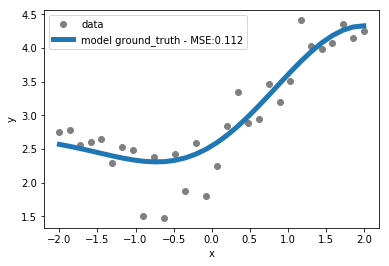

In [2]:
def genData(N,sigma,xstart=-2,xstop=2):
    # generate some data
    x = np.array([np.linspace(xstart, xstop, N)]).T      # x are regularly spaced 
    f_gt = lambda x: 3 + np.sin(x) + 0.5*np.sin(1.5*x-2) # some function
    y = f_gt(x) + sigma*np.random.randn(N,1)             # add random noise
    return x,y,f_gt

x,y,f_gt = genData(N=30,sigma=0.35) # 30 points with additive noise with std of 0.35

# show the data and the underlying ground truth function
pplot(x,y,[[f_gt,'ground_truth']])

## Linear basis function model
In many practical situations the actual function $f(x)$ behind the data is unknown. Therefore the regression problem consists of two parts. First, choose a function and then as the function might have some parameters, estimate the optimal values for the parameters. Usually, for practical reasons the choice is first limited to a class of functions. A flexible and general model we consider here is the so called "linear basis function model".

Let $\psi_0(x),...,\psi_{M}(x)$ be $M+1$ fixed non-linear functions of the input variable $x$. Linear combination of the non-linear functions is then:

$$ f(x;{\bf w})=\sum_{m=0}^{M} w_m \psi_m(x) $$

where the non-linear functions $\psi_m( x)$ are known as the "basis functions" and the coefficients ${\bf w}=[w_0,...,w_M]^T$ are the model parameters. 

There are many possible choices for the basis functions. We will use here the polynomial basis:

$$ \psi_m( x)= x^m $$

Other popular choices for basis functions are Gaussian basis, logistic functions, Fourier basis, etc.

It is also common to have one of the functions equal to 1, i.e. $\psi_0(x)=1$, such that the corresponding parameter $w_0$, also known as "bias", describes the global data offset.  
 
The polynomial basis function model is defined in Python code below:

In [3]:
def psi(x,m):
    """ Polynomial basis function """
    return x**m

def Psi_create_fn(x,M):
    """ Vector of M basis functions """
    return lambda x: np.hstack([psi(x,m) for m in range(M+1)])

def linear_model(w,Psi):
    """ Linear basis function model """
    return Psi.dot(w)

## Least squares model fitting
For a chosen linear basis function model we can find the parameters $\bf w$ that minimize the mean squared error function:

$$ L({\bf w})=\frac{1}{N}\sum_{n=1}^{N} (y_n-f(x_n;{\bf w}))^2 $$

This can be written also in a matrix form:

$$ L({\bf w}) = \frac{1}{N} ({\bf y}- \Psi({\bf x}){\bf w})^T ({\bf y}- \Psi({\bf x}){\bf w})$$

where ${\bf y}=[y_1,...,y_N]^T$  and ${\bf x}=[x_1,...,x_N]^T$ are the observed data points stacked in vectors, and  

$$ \Psi({\bf x})=
\begin{bmatrix}
    \psi_0(x_1)  & \psi_1(x_1) & \dots & \psi_M(x_1) \\
    \psi_0(x_2)  & \psi_1(x_2) & \dots & \psi_M(x_2) \\
    \vdots & \vdots &  \ddots & \vdots \\
    \psi_0(x_N)  & \psi_1(x_N) & \dots & \psi_M(x_N) \\
\end{bmatrix}.
$$

Setting the gradient to zero gives:

$$ \Psi({\bf x})^T\Psi({\bf x}){\bf w}=\Psi({\bf x})^T{\bf y} $$

This can be seen as a set of $M+1$ linear equations that can be solved to find the optimal ${\bf w}_{est}$. One approach is the so called Moore-Penrose pseudo inverse:

$$ {\bf w}_{estimated} = (\Psi({\bf x})^T\Psi({\bf x}))^{-1} \Psi({\bf x})^T{\bf y} $$

While this is a typical textbook method it is also known that it is a poor method in terms of numerical stability. This will be illustrated later.

The code below implements the pseudo-inverse model fitting procedure and also a better linear equations solver based on the matrix singular value decomposition.

In [4]:
def fit_model(x,y,M,method=1,printw=False):
    """ Create an M-th order model and fit it to the data"""
    # create matrix Psi
    Psi_fn = Psi_create_fn(x,M)
    Psi = Psi_fn(x)
    
    # two methods for parameter estimation
    if method==1:
        # Moore-Penrose pseudo-inverse
        w_estimated = np.linalg.inv(Psi.T.dot(Psi)).dot(Psi.T.dot(y))
    else :
        # divide-and-conquer SVD (Lapack xGELSD)
        w_estimated = np.linalg.lstsq(Psi,y,rcond=None)[0]
    # create the estimated model function
    model = lambda x: linear_model(w_estimated,Psi_fn(x))
    
    # model name
    name = 'M=%d' % M
    # print out the estimated coefficients
    if printw:
        print( name + ',w=' + ','.join('{:.2f}'.format(w) for w in np.nditer(w_estimated)))
    return model, name

## Experiments
Now we have all the important functions implemented and we can try them on the synthetic data and observe some important aspects of the regression analysis.

### Experiment 1: Basic models

Try models of order 0,1,2. This should give you the constant, linear and quadratic model. See if you get what is expected. Observe the curves and how the error is decreasing.

M=0,w=2.95
M=1,w=2.95,0.53
M=2,w=2.51,0.53,0.31


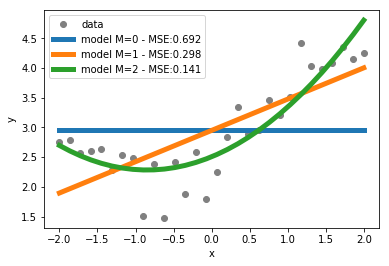

In [5]:
# construct and fit a number of models
models=[fit_model(x,y,M,printw=True) for M in [0,1,2]]
# show the data and the models
pplot(x,y,models)

### Experiment 2: Overfitting

Add more complex models, e.g. M=20 for N=30 data points. Observe how does it look like. This is an example where model is overfitting the data. Then increase the number of data points to for example N=300. With more data te model becomes smoother and closer to the actual function. 


With N = 30 data points.
M=20,w=2.72,-0.07,-5.45,14.57,23.94,-68.62,-33.18,147.83,-1.59,-174.09,49.11,120.82,-54.33,-50.68,28.43,12.61,-8.05,-1.71,1.19,0.10,-0.07


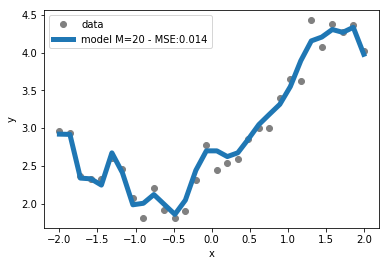

With N = 300 data points.
M=20,w=2.41,0.88,2.56,-3.89,-13.15,17.17,37.65,-34.17,-58.34,36.74,53.27,-23.25,-30.00,8.90,10.54,-2.03,-2.25,0.25,0.27,-0.01,-0.01


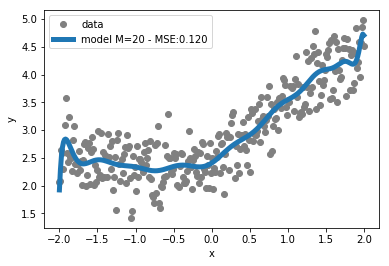

In [6]:
M=20

N=30
x,y,f_gt = genData(N=N,sigma=0.35)
print('With N = {} data points.'.format(N))
pplot(x,y,[fit_model(x,y,M,printw=True)])

N=300
x,y,f_gt = genData(N=N,sigma=0.35)
print('With N = {} data points.'.format(N))
pplot(x,y,[fit_model(x,y,M,printw=True)])

### Experiment 3: Numerical problems with the pseudo-inverse solution

Further increase the model complexity to for example M=30. Observe the result. Then replace the Moore-Penrose pseudo-inverse with the SVD method. The SVD method is more numerically stable and can deal even with such a complex model.

Using pseudo-inverse:
M=30,w=-1.03,-3.26,-2.53,-5.57,-6.26,42.69,32.79,-115.59,-47.82,181.83,33.60,-173.94,-10.23,100.64,-0.27,-32.26,0.58,3.36,0.20,1.09,-0.09,-0.28,-0.04,-0.05,0.03,0.03,-0.01,-0.00,0.00,0.00,-0.00


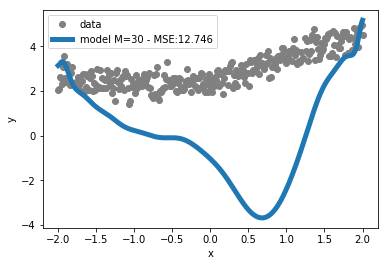

Using SVD:
M=30,w=2.43,1.23,0.93,-13.88,7.34,95.10,-59.89,-295.55,166.11,467.63,-210.23,-329.81,87.48,-79.78,95.20,379.43,-167.77,-370.77,122.40,205.30,-53.95,-72.91,15.50,16.96,-2.92,-2.51,0.35,0.21,-0.02,-0.01,0.00


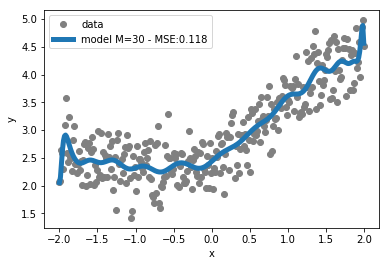

In [7]:
M=30
print('Using pseudo-inverse:')
pplot(x,y,[fit_model(x,y,M,printw=True)])
print('Using SVD:')
pplot(x,y,[fit_model(x,y,M,printw=True,method=2)])

### Experiment 4: Further numerical problems

Try even higher dimensional model, e.g. M=50. Even the SVD model fails here. This is illustrating the general problem of polynomial models with numerical stability as the model complexity increases. Complex models require huge dynamical range. Many other models that model the functions more locally are much more numerically stable.

Using SVD:
M=50,w=0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00


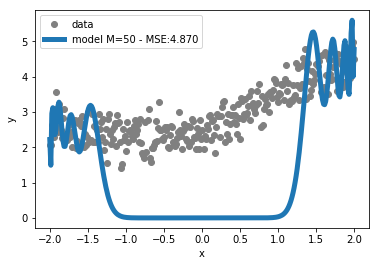

In [8]:
M=50
print('Using SVD:')
pplot(x,y,[fit_model(x,y,M,printw=True,method=2)])

## Cross validation

The experiments above illustrate probably the central problem in the estimation theory: how to find the model of the "right" complexity. The common approach for dealing with model selection is the so called "cross validation". One round of cross validation consist typically of dividing the data into "training" and "test" (or "validation") sets. The training data is used to estimate the model parameters and the test data to evaluate the generalization performance of the model. Typically multiple rounds of cross-validation are done with different data partitions. 

For simplicity we do here just one partition into $75\%$ train and $25\%$ test data.

In [9]:
indices = np.random.permutation(N)
train_idx, test_idx = indices[:75*N//100], indices[75*N//100:]
x_train, x_test = x[train_idx], x[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

Lets now try a set of models of different complexity $M$ and see how they perform on the test and training data.

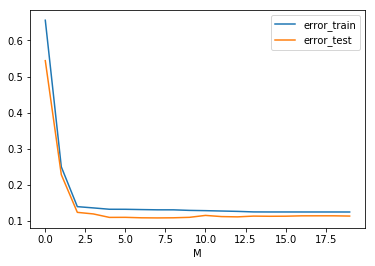

In [10]:
error_train=[]
error_test=[]
for M in range(20):
    model,_=fit_model(x_train,y_train,M,method=2)
    error_train.append(MSE(y_train,model(x_train)))
    error_test.append(MSE(y_test,model(x_test)))


# show
plt.figure()
plt.plot(error_train)
plt.plot(error_test)
plt.xlabel('M')
plt.legend(['error_train','error_test'])
plt.show()

We can observe that for simple models the training and testing errors are both decreasing. After certain model complexity the test error starts increasing while the error on the training data gets always lower. This behavior is known as "over-fitting" the training data.

## Regularization
Another way of dealing with model complexity is to modify the model such that it becomes less prone to over-fitting the data. This method is known as model regularization. For our polynomial model a simple heuristic is to add additional constraints such that the weights $w_m$ are kept small and potentially set to zero if they are not needed. One way of achieving this is by adding an additional term to the optimization function:

$$ L({\bf w})=\frac{1}{N}\{\sum_{n=1}^{N} (y_n-f(x_n;{\bf w}))^2 + \beta {\bf w}{\bf w}^T \}$$

Setting the derivative to zero again gives a linear set of equations:

$$\{\beta+\Psi({\bf x})^T\Psi({\bf x})\}{\bf w}=\Psi({\bf x})^T{\bf y} $$

Let us now take a relatively complex model, e.g. M=20, and plot both the regularized and the non-regularized version and observe the difference: 

M=20,w=2.41,0.88,2.56,-3.89,-13.15,17.17,37.65,-34.17,-58.34,36.74,53.27,-23.25,-30.00,8.90,10.54,-2.03,-2.25,0.25,0.27,-0.01,-0.01
M=20(beta=2.00),w=2.44,0.54,0.51,0.13,0.07,-0.00,-0.04,-0.04,-0.05,-0.03,-0.01,0.00,0.02,0.02,0.01,-0.01,-0.01,0.00,0.00,0.00,-0.00


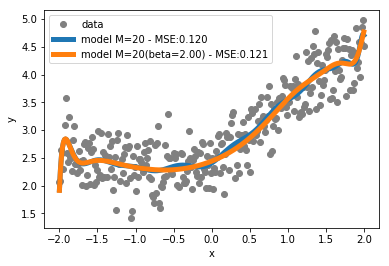

In [11]:
def fit_model_regularized(x,y,M,beta,printw=False):
    """ Create an M-th order model and fit it to the data"""
    Psi_fn=Psi_create_fn(x,M)
    Psi=Psi_fn(x)
    w_estimated = np.linalg.lstsq(beta*np.eye(M+1)+Psi.T.dot(Psi),Psi.T.dot(y),rcond=None)[0]
    # create the estimated model function
    model = lambda x: linear_model(w_estimated,Psi_fn(x))
    
    # model name
    name = 'M=%d(beta=%0.2f)' % (M,beta)
    # print out the estimated coefficients
    if printw:
        print( name + ',w=' + ','.join('{:.2f}'.format(w) for w in np.nditer(w_estimated)))
    return model, name

M=20

pplot(x,y,[fit_model(x,y,M,printw=True),fit_model_regularized(x,y,M,2,printw=True)])


## Summary

A generic class of linear basis function approximation models is introduced. Polynomial basis performance analyzed on a single variable toy problem.

### Key take away message: 

***The main practical challenge in machine learning is generalizing the performance to unseen data***

### Other take aways:

* true model unknown
* usually working with generic model classes
* selecting the right model and model complexity is also known as model selection
* various ways of cross validation are a common way for controlling over-fitting and selecting the right model
* adding additional constraints to control the model complexity is another common tool known as *regularization*
* learning = training = parameter estimation
* inference typically means = applying the model with *trained* parameters on the new unseen data
* large number of data points and complex model lead to many practical numerical problems

# Toward Neural Networks and Deep Learning

Same problem and way of working but working with different models and different optimization techniques.

## Gradient based optimization

Minimizing the loss function $L(\bf{w})$ is done in closed form for this simple linear problem. Modern machine learning is typically dealing with much more complex models, e.g. neural networks, where there might not exist a closed form solution. Therefore generic optimization procedures are usually used. Most approaches rely on the gradient of the loss function. In the simplest form the gradient optimization procedure starts with a random choice for the parameter vector denoted as $\bf{w}_0$. Then a number of iterations is done by updating the parameters in the opposite direction of the loss function gradient:

$ \bf{w}_{k+1}=\bf{w}_k-\gamma \frac{\delta L}{\delta \bf{w}} (\bf{w}_k)$

The parameter $\gamma$ is also known as the step size. If $\gamma$ is small enough, $L(\bf{w}_{k+1}) \le  L(\bf{w}_{k})$. Modern machine learning frameworks include many variations of the gradient based optimization and also perform automatic calculations of the gradients. Typically and you need to define a model and loss function and many optimization procedures can then used. To illustrate this we will use TensorFlow below.


In [12]:
import tensorflow as tf # to run this cell you will need to install TensorFlow

def fit_model_regularized_tf(x,y,M,beta=0,printw=False,nIterations=1000,gamma=0.01):
    """ Create an M-th order model and fit it to the data"""
    
    # model
    tf.reset_default_graph()
    Psi_fn = Psi_create_fn(x,M)
    Psi = tf.constant(Psi_fn(x),dtype=tf.float32)
    y_t = tf.constant(y)
    w   = tf.get_variable('w',[M+1,1])
    y_p = tf.matmul(Psi,w)
    
    # define loss function
    loss = tf.losses.mean_squared_error(labels=y_t, predictions=y_p) + beta* tf.matmul(tf.transpose(w),w)
    
    # define optimizer
    optimizer = tf.train.GradientDescentOptimizer(gamma)
    train     = optimizer.minimize(loss)
    
    # run the optimizer
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(nIterations):
        _, loss_value,w_estimated = sess.run((train, loss,w))
        # print(loss_value)
    
    # create the estimated model function
    model = lambda x: linear_model(w_estimated,Psi_fn(x))
    
    # model name
    name = 'M=%d(beta=%0.2f)(tf)' % (M,beta)
    # print out the estimated coefficients
    if printw:
        print( name + ',w=' + ','.join('{:.2f}'.format(w) for w in np.nditer(w_estimated)))
    return model, name

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Experiment 1: Compare to the closed form optimization

Use small model, e.g. M=3, and change the "hyper-parameters" $\gamma$ and number of iterations. 

M=3,w=2.58,0.65,0.27,-0.05
M=3(beta=0.00)(tf),w=2.58,0.63,0.27,-0.04


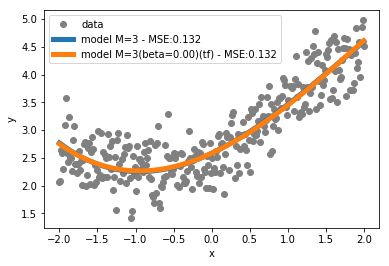

In [13]:
M=3
pplot(x,y,[fit_model(x,y,M,printw=True),fit_model_regularized_tf(x,y,M,gamma=0.01,printw=True)])

Now change to a more complex model, e.g. M=5, and observe how change the "hyper-parameters"  $\gamma$  and number of iterations will change the performance.

M=5,w=2.50,0.67,0.48,-0.07,-0.06,0.00
M=5(beta=0.00)(tf),w=1.65,0.39,1.18,0.25,-0.19,-0.07


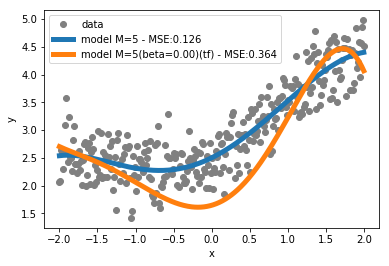

In [14]:
M=5
pplot(x,y,[fit_model(x,y,M,printw=True),fit_model_regularized_tf(x,y,M,gamma=0.001,nIterations=1000,printw=True)])

### Take away messages:

* gradient descent is generic method that can be applied to any differentiable function of arbitrary complexity
* the performance of the gradient descent can be poor and convergence needs to be controlled via a set of *hyper-parameters*
* TensorFlow and other modern machine learning tools work with compute graphs. Typical flow is:
    * define compute graph
    * define operation on the graph
    * map the graph on the compute HW
    * run the computation

## Neural Network Model

Perceptron function:

$$ f_a(\sum_{m=0}^{M} w_m x_m) $$

where $f_a$ is known as the "activation function" and it is usually a non-linear function, e.g. hyperbolic tangent $\tanh$.

![alt_text](images/Sinh_cosh_tanh.svg)

A neural network for simple single variable regression function could be:

$$ f(x;{\bf w})=\sum_{m=0}^{M} w_m \tanh(a_m x+ b_m) $$

where the coefficients ${\bf w}=[w_0,a_0,b_0,...,w_M,a_M,b_M]^T$ are now the model parameters. This can be seen as a 2 layer network.

Linear basis function model as a neural network:

![alt text](images/linear_as_NN.svg)

Simple neural network for single variable regression:

![alt text](images/NN_for_regression.svg)


### History

Perceptron - single layer:
- Warren McCulloch and Walter Pitts  (1943), "A Logical Calculus of Ideas Immanent in Nervous Activity"
- Frank Rosenblatt (1957), "The Perceptron--a perceiving and recognizing automaton"
[perceptron](images/Mark_I_perceptron.jpeg) Source(Wikipedia)

Neural networks - multiple layers:
- Rumelhart, D. E., Hinton, G. E., and Williams, R. J. (1986). "Learning representations by back-propagating errors"
- George Cybenko (1989), "Approximation by superpositions of a sigmoidal function"


We can now build the model using high level TensorFlow API called Keras: 

In [15]:
from tensorflow import keras

def fit_model_nn(x,y,M,printw=False,nIterations=1000,gamma=0.1):
    """ Create an M-th order model and fit it to the data"""
    
    # model
    input  = keras.Input(shape=(1,),name='x')
    layer  = keras.layers.Dense(M,activation='tanh',name='Layer1')(input)
    layer  = keras.layers.Dense(1,activation='linear',use_bias=False,name='Layer2')(layer)
    model  = keras.Model(inputs=input, outputs=layer)
    
    # optimizer
    model.compile(optimizer=keras.optimizers.SGD(lr=gamma),loss='mse')
    
    # run
    model.fit(x,y,epochs=nIterations,verbose=0)
    
    # create the estimated model function
    model_ = lambda x: model.predict(x)
    
    # model name
    name = 'M=%d(nn)' % (M)  
    # print out the estimated coefficients
    if printw:
        print('NN model:')
        print(model.summary())
        for layer in model.layers:
            for w_estimated in layer.get_weights():
                print( name +layer.name+',w=' + ','.join('{:.2f}'.format(w) for w in np.nditer(w_estimated)))

    return model_, name

Using the model on the data and comparing to the polynomial model:

M=10,w=2.47,0.73,0.62,-0.42,-0.12,0.44,-0.02,-0.18,0.01,0.02,-0.00
NN model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 1)                 0         
_________________________________________________________________
Layer1 (Dense)               (None, 10)                20        
_________________________________________________________________
Layer2 (Dense)               (None, 1)                 10        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
M=10(nn)Layer1,w=-0.07,0.14,0.37,-0.06,0.93,-1.11,-0.17,0.30,0.08,-0.06
M=10(nn)Layer1,w=1.12,-0.39,0.10,1.27,-0.98,0.73,0.26,-0.04,-0.84,1.54
M=10(nn)Layer2,w=0.87,-0.27,-0.31,1.07,0.88,-0.80,0.24,-0.28,-0.58,1.54


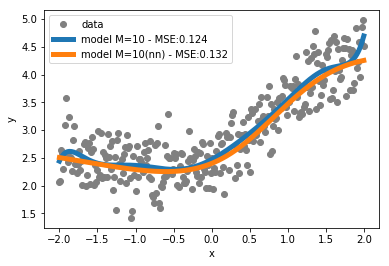

In [16]:
M=10
pplot(x,y,[fit_model(x,y,M,printw=True),fit_model_nn(x,y,M,printw=True)])

Observations:

* Although it has 3x more parameters the neural network model seems more stable than the polynomial. 
* The gradient procedure works much better on this model.

## Generalization on the new data - extrapolation

Until now we fitted our models on data where the input variable $x$ was in the range $[-2,2]$. What will happen if suddenly we need to address the data in a wider range, e.g. $[-2,4]$  

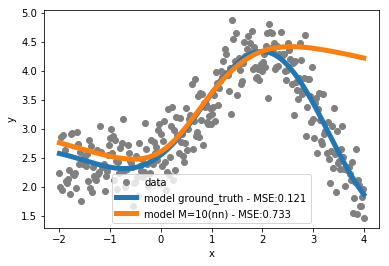

In [17]:
x_new,y_new,f_gt = genData(N=300,sigma=0.35,xstart=-2,xstop=4)
pplot(x_new,y_new,[[f_gt,'ground_truth'],fit_model_nn(x,y,M)])

If we can collect the data in the new unseen areas we can easily reuse all the infrastructure and *retrain* the model:

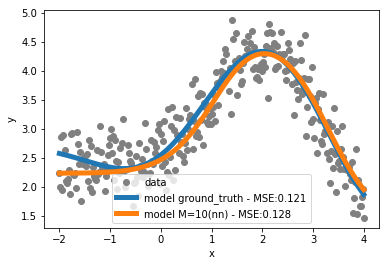

In [18]:
pplot(x_new,y_new,[[f_gt,'ground_truth'],fit_model_nn(x_new,y_new,M)])

### Key take away message: 

***The main practical challenge in machine learning is generalizing the performance to unseen data***

### Other take aways:

* Deep learning - neural networks: more generic and more complex
* *defining model* = *defining network topology/architecture*
* Generic optimization tools - work well *usually*
* Compared to other models neural:
    * Pro: flexible and easy to scale
    * Con: usually not optimal in terms of computation and storage